# Fitting Tree Based Models

In [2]:
# Import the modules made for feature imputation/engineering/selection
import sys
sys.path.insert(0,'..')
import FeatureEngineering_Module as fe
import Imputation_Module as imp
import Encoding_Module as ec

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
sns.set(style = "whitegrid")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [3]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [4]:
train_df, test_df = imp.impute_data()
train = fe.FeatureEngineering(train_df)
test = fe.FeatureEngineering(test_df)

In [5]:
train, test = ec.encode(train, test)

In [6]:
# Isolating the target feature and applying log transformation for normality
Y = train["SalePrice"]
X = train.drop("SalePrice", axis = 1)

In [7]:
print("train shape: " + str(X.shape))
print("test shape: " + str(test.shape))

train shape: (1456, 49)
test shape: (1459, 49)


## Model Evaluation

In [9]:
def model_eval(model, grid_para, X = X, Y = Y, ):
    grid = GridSearchCV(model, grid_para, cv = 5)
    grid.fit(X, Y)
    grid.best_params_
    grin.best_score_
    score = model.score(X,Y)
    pred = model.predict(X)
    RMSLE = np.sqrt(mean_squared_error(pred, Y))
    print(str(model).split("(")[0] + " model evaluation")
    print("-"*50)
    print("Mean R-square with 5 Fold Cross Validation: " + str(round(score, 5)))
    print("RMSLE: " + str(round(RMSLE, 5)))
    
    return np.exp(pred)

## Random Forest

In [10]:
randomForest = RandomForestRegressor(random_state = 0)

In [11]:
grid_para_forest = {'n_estimators': range(10, 500, 20)}

In [12]:
grid_search_forest = GridSearchCV(randomForest, 
                                  grid_para_forest,
                                  cv=3, n_jobs = 5, verbose = 1)
grid_search_forest.fit(X, Y)

print(grid_search_forest.best_params_)
print(grid_search_forest.best_score_)
print(grid_search_forest.best_estimator_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    7.9s
/Users/hb/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=5)]: Done  75 out of  75 | elapsed:   26.6s finished


{'n_estimators': 190}
0.8720439950972431
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=190, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)


In [15]:
bestmodel = grid_search_forest.best_estimator_
pred = bestmodel.predict(X)
RMSLE = np.sqrt(mean_squared_error(pred, Y))
RMSLE

9610.67598987616

In [16]:
grid_search_forest.score(X, Y)

0.9842871807654604

In [17]:
grid_search_forest.best_estimator_.score(X, Y)

0.9842871807654604

Text(0.5, 1.0, 'Feature Importance Plot of 500-Tree GBM')

<Figure size 1440x720 with 0 Axes>

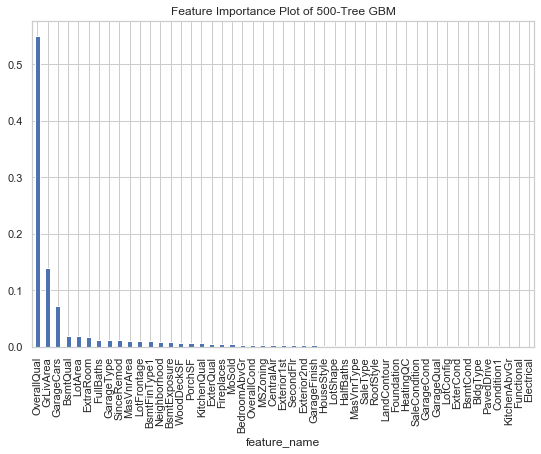

In [25]:
sorted_importance = sorted(zip(X.columns, bestmodel.feature_importances_), key=lambda t:t[1], reverse=True)
a, b = zip(*sorted_importance) # this splits the list of tuples into two lists
plt.figure(figsize = (20,10))
pd.DataFrame({'feature_name':a, 'importance_score':b}).plot.bar(x='feature_name',y='importance_score', legend=None);
plt.title('Feature Importance Plot Random Forest')

Text(0, 0.5, 'Predicted Value')

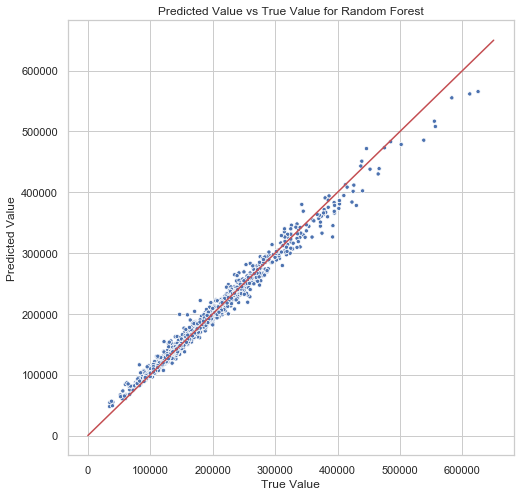

In [26]:
plt.figure(figsize=(8,8))
sns.scatterplot(x = Y, y = pred, size = 8, legend = False)
plt.plot([0,650000],[0,650000], color = "r")
plt.title("Predicted Value vs True Value for Random Forest")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")

## Gradient Boosting

In [21]:
gbm = GradientBoostingRegressor(random_state = 0)

In [30]:
grid_para_gb = {'n_estimators': range(400, 500, 10),
                   'learning_rate':[0.01,0.05,0.1],
                   'max_depth':[3,5],
                   'max_features':[5,10]}

In [31]:
grid_search_gb = GridSearchCV(gbm, grid_para_gb, cv=5, n_jobs = 5, verbose = 1)
grid_search_gb.fit(X, Y)

print(grid_search_gb.best_params_)
print(grid_search_gb.best_score_)
print(grid_search_gb.best_estimator_)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    3.2s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   13.6s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:   29.6s
[Parallel(n_jobs=5)]: Done 600 out of 600 | elapsed:   41.2s finished


{'learning_rate': 0.05, 'max_depth': 3, 'max_features': 10, 'n_estimators': 490}
0.9105282052116438
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=3,
                          max_features=10, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=490,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [32]:
bestmodel = grid_search_gb.best_estimator_
pred = bestmodel.predict(X)
RMSLE = np.sqrt(mean_squared_error(pred, Y))
RMSLE

13173.237506819252

Text(0.5, 1.0, 'Feature Importance Plot of GBM')

<Figure size 1440x720 with 0 Axes>

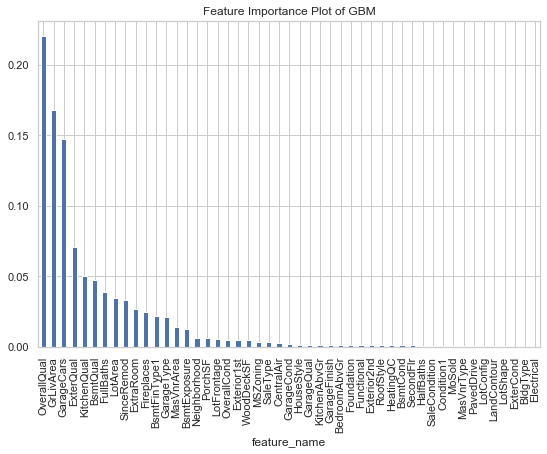

In [36]:
sorted_importance = sorted(zip(X.columns, bestmodel.feature_importances_), key=lambda t:t[1], reverse=True)
a, b = zip(*sorted_importance) # this splits the list of tuples into two lists
plt.figure(figsize = (20,10))
pd.DataFrame({'feature_name':a, 'importance_score':b}).plot.bar(x='feature_name',y='importance_score', legend=None);
plt.title('Feature Importance Plot of GBM')

Text(0, 0.5, 'Predicted Value')

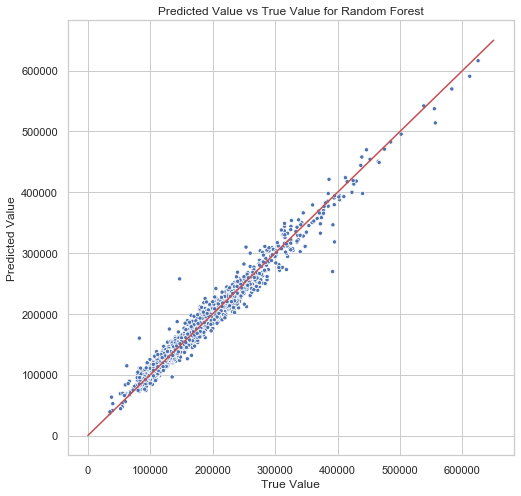

In [38]:
plt.figure(figsize=(8,8))
sns.scatterplot(x = Y, y = pred, size = 8, legend = False)
plt.plot([0,650000],[0,650000], color = "r")
plt.title("Predicted Value vs True Value for Random Forest")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")

## Format for Kaggle Submission

In [13]:
# sample = pd.read_csv("../sample_submission.csv", index_col = "Id")
# sample["SalePrice"] = pred
# sample.to_csv("gb.csv")

In [ ]:
# sample